In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns    
import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('Vodafone_Customer_Churn_Sample_Dataset.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Convert TotalCharges from string to numeric datatype.

In [3]:
data['TotalCharges'].dtype

dtype('O')

In [4]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].dtype

dtype('float64')

In [5]:
df = data.copy()

## Feature Engineering

Encoding the binary variables as 1 or 0

In [6]:
df.gender = df.gender.replace({'Female':1,'Male':0})
binary_cols = ['SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','Churn',
               ]

for col in binary_cols:
    df[col] = df[col].replace({'Yes':1, 'No':0})


One-hot encoding the categorical variables with more than 2 categories

In [7]:
multi_cat_cols = ['MultipleLines','InternetService','Contract','PaymentMethod','OnlineSecurity','OnlineBackup','DeviceProtection',
               'TechSupport','StreamingTV','StreamingMovies']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')

As described in the EDA, there are the 11 null values for TotalCharges with 0 (these are customers with tenure of 0, i.e. new customers who have not been charged anything yet). 

We set the TotalCharges for these as 0, as they may not have been charged anything yet due to their new billing cycle being yet to start.

In [9]:
df[df['TotalCharges'].isna()][['customerID','tenure','MonthlyCharges','TotalCharges']]

,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN
3331,7644-OMVMY,0,19.85,NaN
3826,3213-VVOLG,0,25.35,NaN
4380,2520-SGTTA,0,20.00,NaN
5218,2923-ARZLG,0,19.70,NaN
6670,4075-WKNIU,0,73.35,NaN


In [10]:
df.loc[df['tenure']==0, 'TotalCharges'] = 0

In [11]:
import plotly.express as px
df_for_corr = df.drop('customerID', axis=1) #dropping customerID for correlation matrix because it's a string
corr = df_for_corr.corr()

fig = px.imshow(corr, text_auto=False, aspect="auto", height=800)

fig.update_traces(hovertemplate='Correlation: %{z:.2f}')

fig.update_layout(xaxis_side="top")

fig.show()

As described in the EDA, some of the one-hot encoded categorical variables are 100% correlated (redundant) with each other (e.g. InternetService_No and OnlineBackup_No internet service etc.). 

So we remove the redundance ones among these to avoid multicollinearity before modeling.
- PhoneService vs MultipleLines: So drop PhoneService (since MultipleLines contains that info already).
- InternetService_No vs all _No internet service dummies: So drop the _No internet service columns (since InternetService_No already captures that condition).



Also since the Churn data is imbalanced, we will have to use class weights. Getting the class weights:

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df['Churn']),
                                     y=df['Churn'])
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)

{0: 0.6806146115191342, 1: 1.8841626538255751}


## Model Training

CustomerID is not useful for prediction, so we will drop it but keep it as id_train and id_test for mapping back predictions later.
We also keep the same churn ratio in train/test split using  stratify=y .

In [13]:
from sklearn.model_selection import train_test_split

customer_ids = df['customerID'] # keeping customerID separately to map back later on

X = df.drop(['customerID','Churn','PhoneService','OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 
       'StreamingTV_No internet service', 
       'StreamingMovies_No internet service'], axis=1) # removing customerID, target variable and redundant variables as explained in EDA
y = df['Churn']

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.2, stratify=y, random_state=42  # stratify to maintain same distribution of target variable in train and test sets
)

print("Train size:", y_train.shape[0])
print("Test size:", y_test.shape[0])
print("Churn distribution in train:\n", y_train.value_counts(normalize=True))

Train size: 5634
Test size: 1409
Churn distribution in train:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


Start with a baseline model of Logistic Regression.

### Logistic Regression (Baseline Model)

Confusion Matrix:
 [[748 287]
 [ 80 294]]


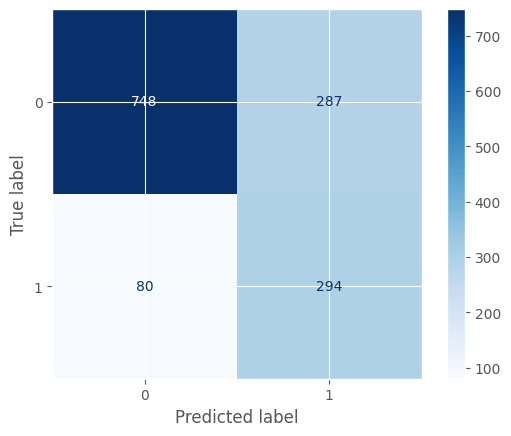

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay


log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42) # with class weights to handle imbalance
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()


- True negatives (TN):748 - Predicted No Churn, Actual No Churn
- False negatives (FN):  80 - Predicted No Churn, Actual Churn
- False positives (FP):  287 - Predicted Churn, Actual No Churn
- True positives (TP):  294 - Predicted Churn, Actual Churn 

In [15]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC Score: 0.8419101500942933


For class 0 (No churn) 
- Precision = 0.90, i.e. when the model predicts “No churn,” it’s right 91% of the time
- Recall = 0.72, i.e. oit correctly catches 70% of all loyal customers

For class 1 (churn)
- Precision = 0.51, i.e. when the model predicts “Churn,” it’s only right half the time
- Recall = 0.79, i.e. it catches 80% of all churners

Overall:
- Accuracy = 70% - correct predictions of Churn or No Churn.
- ROC AUC = 0.84, which suggests strong discriminative ability.

i.e, the model prioritizes recall for churners, which is good (we don’t want to miss them)
But there are also many false alarms (FP = 307), meaning you’d waste retention efforts on some loyal customers.
•	In real life, this trade-off is OK — better to annoy a few loyal customers with “extra love” than miss churners.

In [16]:
import numpy as np

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


In [17]:
feature_importance.head(10)

,Feature,Coefficient
10,InternetService_Fiber optic,1.197944
22,StreamingMovies_Yes,0.411600
15,PaymentMethod_Electronic check,0.406025
21,StreamingTV_Yes,0.386103
5,PaperlessBilling,0.337956
9,MultipleLines_Yes,0.321199
8,MultipleLines_No phone service,0.183391
1,SeniorCitizen,0.156085
16,PaymentMethod_Mailed check,0.050385
19,DeviceProtection_Yes,0.035985


In [18]:
feature_importance.tail(10)

,Feature,Coefficient
6,MonthlyCharges,-0.017327
0,gender,-0.030916
4,tenure,-0.048164
18,OnlineBackup_Yes,-0.074747
3,Dependents,-0.228951
20,TechSupport_Yes,-0.273493
17,OnlineSecurity_Yes,-0.337222
12,Contract_One year,-0.716319
11,InternetService_No,-1.244213
13,Contract_Two year,-1.406992


- Customers with Fiber optic service (compared to baseline DSL), streaming TV/movies, or no phone service have a higher risk of churn.
- Customers with longer contracts (compared to shorter month-to-month), dependents, online security, or tech support are less likely to churn.

In [19]:

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
})


feature_importance['Parent'] = feature_importance['Feature'].apply(lambda x: x.split('_')[0])


grouped_importance = feature_importance.groupby('Parent')['Coefficient'].apply(lambda x: np.sum(np.abs(x))).sort_values(ascending=False)

print(grouped_importance)

Parent
InternetService     2.442157
Contract            2.123310
MultipleLines       0.504590
PaymentMethod       0.460006
StreamingMovies     0.411600
StreamingTV         0.386103
PaperlessBilling    0.337956
OnlineSecurity      0.337222
TechSupport         0.273493
Dependents          0.228951
SeniorCitizen       0.156085
OnlineBackup        0.074747
tenure              0.048164
DeviceProtection    0.035985
gender              0.030916
Partner             0.019794
MonthlyCharges      0.017327
TotalCharges        0.000225
Name: Coefficient, dtype: float64


### Comparing models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Neural Net": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
}

results = {}

# Loop through models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    results[name] = {
        "ROC AUC": roc_auc_score(y_test, y_prob),
        "Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Print summary
for name, res in results.items():
    print(f"\n{name} - ROC AUC: {res['ROC AUC']:.3f}")
    # print("Confusion Matrix:\n", res["Confusion Matrix"])
    # print("\nClassification Report:\n", res["Report"])

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Naive Bayes...
Training kNN...
Training XGBoost...
Training CatBoost...
Training Neural Net...

Logistic Regression - ROC AUC: 0.842

Decision Tree - ROC AUC: 0.658

Random Forest - ROC AUC: 0.824

Naive Bayes - ROC AUC: 0.824

kNN - ROC AUC: 0.755

XGBoost - ROC AUC: 0.821

CatBoost - ROC AUC: 0.840

Neural Net - ROC AUC: 0.831


In [21]:
model_scores = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC_AUC': [res['ROC AUC'] for res in results.values()]
})
model_scores.sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)

,Model,ROC_AUC
0,Logistic Regression,0.841910
1,CatBoost,0.839545
2,Neural Net,0.830866
3,Random Forest,0.824086
4,Naive Bayes,0.823909
5,XGBoost,0.821065
6,kNN,0.754508
7,Decision Tree,0.658082


Logistic regression, CatBoost and Neural Net and are good candidates for the best models.
Next, we will do hyperparameter tuning on these.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']  # supports l1/elasticnet
}

grid = GridSearchCV(
    LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    param_grid, scoring='roc_auc', cv=3, n_jobs=-1
)

grid.fit(X_train, y_train)
print("Logistic Regression Best Params:", grid.best_params_)
print("Logistic Regression ROC AUC:", grid.best_score_)

Logistic Regression Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression ROC AUC: 0.8458388544087367


In [23]:
from catboost import CatBoostClassifier

param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

grid = GridSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    param_grid, scoring='roc_auc', cv=3, n_jobs=-1
)

grid.fit(X_train, y_train)
print("CatBoost Best Params:", grid.best_params_)
print("CatBoost Best ROC AUC Score:", grid.best_score_)

CatBoost Best Params: {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
CatBoost Best ROC AUC Score: 0.8506796085500105


In [24]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (64,32)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300,400]
}

grid = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid, scoring='roc_auc', cv=3, n_jobs=-1
)

grid.fit(X_train, y_train)
print("MLP Best Params:", grid.best_params_)
print("MLP Best ROC AUC Score:", grid.best_score_)

MLP Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001, 'max_iter': 300}
MLP Best ROC AUC Score: 0.8305627200343695


CatBoost is the one which has the best ROC AUC Score with hyperparameter tuning.

In [25]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=y_train)

class_weights = list(weights)  
print(class_weights)

[0.6805991785455424, 1.8842809364548494]


### Prediction using the best model (CatBoost with hyperparameter tuning)

In [26]:
from catboost import CatBoostClassifier, Pool

best_cat = CatBoostClassifier(
    iterations=200,
    depth=4,
    learning_rate=0.05,
    class_weights=class_weights,
    random_state=42,
    verbose=0
)
best_cat.fit(X_train, y_train)

Confusion Matrix:
 [[749 286]
 [ 75 299]]


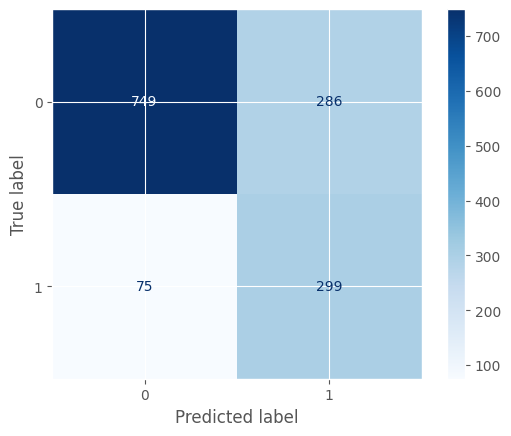

In [27]:
y_pred = best_cat.predict(X_test)
y_prob = best_cat.predict_proba(X_test)[:,1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [28]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC AUC Score: 0.84708853238265


In [29]:
import shap

explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_test)


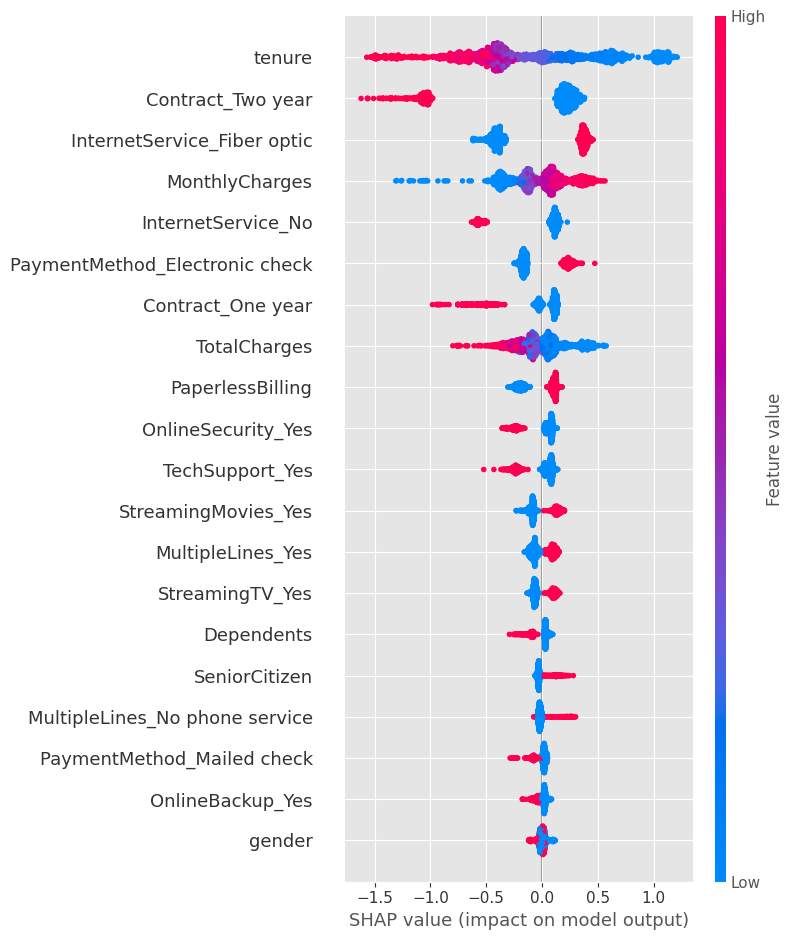

In [30]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

The SHAP summary plot shows the most important features for predicting churn:
- Tenure is the most important feature: longer tenure (or more loyal customers) = lower churn risk, shorter tenure or newer customers = higher churn risk.
- Contract_Two year is next: Similar to Tenure - if customer has been with the company for more than 2 years,  monthly charges = higher churn risk, lower monthly charges = lower). Also a clear separation - the model sees 2-year contracts as extremely stable compared to other contracts
- InternetService_Fiber optic - Customers with Fiber optic service are more likely to churn compared to the baseline (DSL). Customers without Fiber optic (DSL/No service) are more stable, less likely to churn. Since dots are completely separated, the model sees fiber optic status as a very clear binary signal for churn.
- Monthly charges - Customers paying more are more likely to churn, but it’s not as binary as contract type — model sees nuanced impact.

In [31]:
id_test

437     4376-KFVRS
2280    2754-SDJRD
2235    9917-KWRBE
4460    0365-GXEZS
3761    9385-NXKDA
           ...    
5143    5204-HMGYF
4439    9950-MTGYX
3857    3675-EQOZA
4758    3646-ITDGM
5613    3913-FCUUW
Name: customerID, Length: 1409, dtype: object

In addition to the binary predictions (1 or 0), we can also get the predicted probabilities of churn (between 0 and 1) for each customer. This can be useful for prioritizing retention efforts on customers by categorising those with the highest risk of churn.

In [32]:
y_prob = best_cat.predict_proba(X_test)[:, 1]
y_pred = best_cat.predict(X_test)

results = pd.DataFrame({
    'customerID': id_test,
    'Churn_Pred': y_pred,
    'Churn_Prob': y_prob
}).reset_index(drop=True)

In [33]:
def risk_bucket(p):
    if p >= 0.8:
        return "Very High"
    elif p >= 0.6:
        return "High"
    elif p >= 0.4:
        return "Medium"
    else:
        return "Low"

results['Risk_Bucket'] = results['Churn_Prob'].apply(risk_bucket)

In [34]:
results

,customerID,Churn_Pred,Churn_Prob,Risk_Bucket
0,4376-KFVRS,0,0.058742,Low
1,2754-SDJRD,1,0.901515,Very High
2,9917-KWRBE,0,0.191730,Low
3,0365-GXEZS,1,0.553184,Medium
4,9385-NXKDA,0,0.029972,Low
...,...,...,...,...
1404,5204-HMGYF,0,0.119397,Low
1405,9950-MTGYX,0,0.028837,Low
1406,3675-EQOZA,0,0.313089,Low
1407,3646-ITDGM,0,0.037072,Low


In [35]:
risk_distribution = results.groupby('Risk_Bucket')['customerID'].count().reset_index()
risk_distribution.columns = ['Risk_Bucket', 'Customer_Count']
print(risk_distribution)

  Risk_Bucket  Customer_Count
0        High             283
1         Low             729
2      Medium             207
3   Very High             190


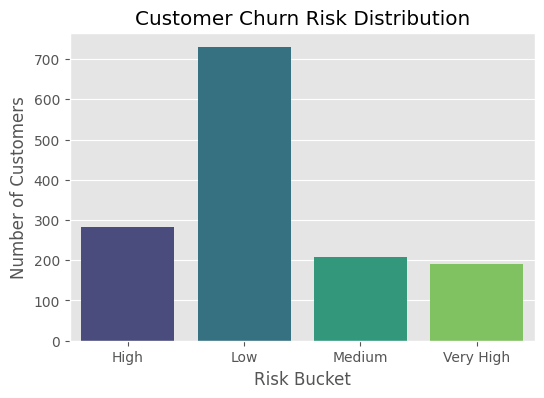

In [36]:
plt.figure(figsize=(6,4))
sns.barplot(data=risk_distribution, x='Risk_Bucket', y='Customer_Count', palette='viridis')
plt.title('Customer Churn Risk Distribution')
plt.xlabel('Risk Bucket')
plt.ylabel('Number of Customers')
plt.show()

In [40]:
results.to_csv("../dept-churn-prediction-email-gen/churn_results.csv", index=False)